# Query-by-Example (QbE) Search Using DTW

## Preliminary

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
from __future__ import division
from __future__ import print_function
from os import path
from python_speech_features import delta
from python_speech_features import mfcc
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
import sys
import simpleaudio as sa
from pydub import AudioSegment
from pydub.playback import play
from shennong.audio import Audio
from shennong.features.processor.mfcc import MfccProcessor
from shennong.features.postprocessor.delta import DeltaPostProcessor
from shennong.features.postprocessor.cmvn import CmvnPostProcessor
from progress.bar import Bar
from datetime import datetime
from nltk import word_tokenize
import nltk
nltk.download('punkt')
import Levenshtein as lev
import pickle

sys.path.append("..")
sys.path.append(path.join("..", "utils"))

from speech_dtw import qbe

/home/josh/miniconda3/lib/python3.7/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
/home/josh/miniconda3/lib/python3.7/site-packages/pydub/utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)
[nltk_data] Downloading package punkt to /home/josh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Extract features

In [5]:
def get_mfcc_dd(wav_fn):
    """Return the MFCCs with deltas and delta-deltas for a audio file."""
    audio = Audio.load(wav_fn)
    processor = MfccProcessor(sample_rate=audio.sample_rate, window_type="hamming",frame_length=0.025, frame_shift=0.01,
                              cepstral_lifter=26.0,low_freq=0, vtln_low=60, vtln_high=7200, high_freq=audio.sample_rate/2)
    d_processor = DeltaPostProcessor(order=2)
    mfcc_static = processor.process(audio.channel(0), vtln_warp=1.0)
    mfcc_deltas = d_processor.process(mfcc_static)
    #print(mfcc_static.shape, mfcc_deltas.shape)
    features = mfcc_deltas._to_dict()["data"]
    features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    #print(features.shape)
    return features

In [6]:
#words_txt = 'english_words/common_words_500.txt'
#words_dir = 'english_words/500_common'
#word_wav = 'common_word_*.wav'
ftitle = 'kunwok_original_words'
plot_title = ' (Kunwinjku Original Words)'
#words_txt = 'english_words/redfern_words.txt'
words_dir = 'kunwok_words/common_words'
word_wav = '*.wav'
target_speech_dir = 'kunwok_speech/interview_orgnl'
#target_speech_dir = 'redfern_rspk'
target_speech_txt = '*.txt'
target_speech_wav = '*.wav'

## Take Query Words

In [7]:
word_list = []
for wav_fn in sorted(glob.glob(path.join(words_dir, word_wav))):
    query = {} 
    txt_file = open(wav_fn.replace('wav','txt'), "r")
    query["word"] = txt_file.read()
    print(query["word"], end=' ')
    rate, signal = wav.read(wav_fn)
    length = len(signal) / rate * 1000
    query_mfcc = get_mfcc_dd(wav_fn)   
    query["length"] = length
    query["data"] = query_mfcc
    query["audio"] = AudioSegment.from_file(wav_fn, format="wav")
    query["thres"] = 1
    #play(query["audio"])
    word_list.append(query)


wanjh kinga manekke namekke manme kabirri-nan kabirri-bolbme ngimeng nawu birri-wam njamed wurdurd ngad ngadberre wurdwurd kunak kumekke ku-denge bi-kang ngalmekke borrhkeng kandji kabirri-re bedda karuy bolkkime niwirrinj dabborrabbolk bebhmeng minj man-berrk ngarrben-bukkan birri-yawam manu kun-dulk birri-kadjuy djenj bebmeng munguy ku-red kabirri-yime bininj bi-mey bi-kurrmeng kondah birri-ni bushwalking birri-yoy nameh road bidbom dabuno kun-wale ngarri-re kunred

 ku-ronj kayime daluk kore 

In [16]:
print(len(word_list))
print(word_list[4]["word"])
play(word_list[4]["audio"])
#print(query["data"].shape)

32
bolkkime


## Take Target Speech Utterances

In [21]:
speech_utt = []
for wav_fn in sorted(glob.glob(path.join(target_speech_dir, target_speech_wav))):
    dic = {}
    #print(wav_fn)
    dic["audio"] = AudioSegment.from_file(wav_fn, format="wav")
    dic["data"] = get_mfcc_dd(wav_fn)
    txt_file = open(wav_fn.replace('wav','txt'), "r")
    dic["word"] = txt_file.read()
    speech_utt.append(dic)

print(speech_utt[5]['word'])  
#play(speech_utt[5]['audio'])

ngandi-nan ngadberre kun-wale kabirri-nan


bedmanwali
kunukka bu nga-wam pre-school but


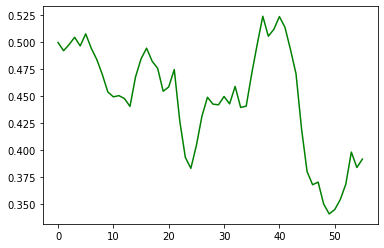

In [24]:
print(word_list[1]["word"])
print(speech_utt[30]["word"])
#print(redfern_word_list[1]["data"], redfern_rspk[2]["data"])
#print(np.float64(redfern_word_list[1]["data"]), np.float64(redfern_rspk[2]["data"]))
sweep_original = qbe.dtw_sweep(np.float64(word_list[1]["data"]), np.float64(speech_utt[30]["data"]))
plt.plot(sweep_original,color='green')
#play(word_list[2]['audio'])
#play(speech_utt[40]["audio"])

In [25]:
print(len(speech_utt))

56


In [37]:
from tqdm import tqdm
from statistics import mean
result = []
num_uttword = 0
num_match = 0 
num_prediction = 0
num_nomatch = 0
thres_distance = 0
#common_words_penalty = 1.2
correct_dtw_score = []
incorrect_dtw_score = []

def sortThird(val): 
    return val[2]  

for uttr in tqdm(range(0,len(speech_utt))):
    dic = {}
    dic['correct_words'] = []
    dic['incorrect_words'] = []
    dic['correct_dtw'] = []
    dic['incorrect_dtw'] = []
    prediction = []
    match = set()
    close_words = set()
    length = len(speech_utt[uttr]["data"])/100
    #print('Length of the Utterance: ' +str(length)+'s')
    #print(len(speech_utt[uttr]["audio"]))
    for query in word_list:        
        query_word = query["word"].lower()
        query_mfcc = np.float64(query["data"])
        search_mfcc = np.float64(speech_utt[uttr]["data"])
        dtw_costs = qbe.dtw_sweep(query_mfcc, search_mfcc)
        min_dtw = np.min(dtw_costs)
        utt_sent = word_tokenize(speech_utt[uttr]['word'].lower().replace('-',''))
        time = dtw_costs.index(min_dtw)*3/100
        hasMatch = False
        dic['sentence'] = utt_sent
        
        #if min_dtw < 0.3178:
            #prediction.append((query_word, time, min_dtw))
      
        for utt_word in utt_sent:
            if lev.distance(query_word,utt_word)<=thres_distance:
                dic['correct_words'].append(utt_word)
                dic['correct_dtw'].append(min_dtw)
                correct_dtw_score.append(min_dtw)
                #dic['time']=dtw_costs.index(min_dtw)*3/100
                #length = len(dtw_costs)*3/100
                #sweep_original = qbe.dtw_sweep(np.float64(query["data"]), np.float64(speech_utt[uttr]["data"]))
                #plt.plot(sweep_original,color='green')
                #print('{:<20}'.format(utt_word), end=' ')
                #print('{:<20}'.format(query_word), end=' ')
                #print("%0.3f" % min_dtw, end='\t\t')
                #print(dic['time'], length)
                hasMatch = True
                #print('spotted_words:')
                #print(query_word,min_dtw)
                #play(query['audio'])
                #play(speech_utt[uttr]["audio"])
                break
                
        if hasMatch == False:
            dic['incorrect_words'].append(query_word)
            dic['incorrect_dtw'].append(min_dtw)
            incorrect_dtw_score.append(min_dtw)
            #print('incorrect_words:')
            #print(query_word,min_dtw)        
        
    num_uttword += len(utt_sent)
    #num_prediction += len(match)
    num_match += len(dic['correct_words'])
    num_nomatch += len(dic['incorrect_words'])
    
    #prediction.sort(key = sortThird)
    #prediction.sort(key = sortSecond)
    #print(speech_utt[uttr]['word'])
    #for w in prediction:
        #string = str('|%0.1f'% w[1])+'s|'+str(w[0])+str('|DTW:%0.3f|'% w[2])
        #left = string.rjust(int(20*w[1]+len(string)),'-')
        #full = left.ljust(int(20*length),'-')
        #print(full,end='|\n')
        #print(int(10*spotted[1])*' '+ spotted[0] +' '+ str("%0.3f" % spotted[1])+int(10*spotted[3])*' '+'|')
    #print('\n')
    #word_recognition_rate, precision, recall = get_score(num_uttword, num_spotted, num_prediction, num_unspotted)
    
    result.append(dic)
#    if len(correct_dtw_score)>0:
#        print('\nCorrect DTW Average:', end=' ')
#        print(mean(correct_dtw_score))
#    print('Incorrect DTW Average:', end=' ')
#    print(mean(incorrect_dtw_score))
#    print('\n') 
print('\nCorrect DTW Average:', end=' ')
print(mean(correct_dtw_score))
print('Incorrect DTW Average:', end=' ')
print(mean(incorrect_dtw_score))
print('Number of Matching Words:', end=' ')
print(num_match)
print('Done\n') 

100%|██████████| 56/56 [00:43<00:00,  1.29it/s]


Correct DTW Average: 0.24357946005053716
Incorrect DTW Average: 0.3868489479261498
Number of Matching Words: 111
Done



In [38]:
print('\nCorrect DTW Average:', end=' ')
print(mean(correct_dtw_score))
print('Incorrect DTW Average:', end=' ')
print(mean(incorrect_dtw_score))
print('Number of Total Words:', end=' ')
print(num_uttword)
print('Number of Match Words:', end=' ')
print(num_match)


Correct DTW Average: 0.24357946005053716
Incorrect DTW Average: 0.3868489479261498
Number of Total Words: 206
Number of Match Words: 111


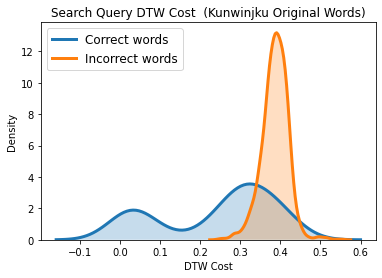

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(correct_dtw_score, shade=True, linewidth = 3, label = 'Correct words')
sns.kdeplot(incorrect_dtw_score, shade=True, linewidth = 3, label = 'Incorrect words')
    
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Search Query DTW Cost ' + plot_title)
plt.xlabel('DTW Cost')
plt.ylabel('Density')
plt.savefig(ftitle+'_dtw.png', dpi=400)

In [40]:
def get_score(dtw_threshold, match_dtw_score, nomatch_dtw_score, word_count):
    num_spotted = len(list(filter(lambda x: x < dtw_threshold, match_dtw_score)))
    num_uttword = word_count
    num_incorrect = len(list(filter(lambda x: x < dtw_threshold, nomatch_dtw_score)))
    #print(num_spotted, num_incorrect)
    num_match = num_incorrect + num_spotted
    num_unspotted = len(match_dtw_score) - num_spotted
    
   #print(num_spotted, num_uttword, num_incorrect, num_match, num_unspotted)
       
    #word_recognition_rate = num_spotted/num_uttword
    precision = num_spotted/num_match
    recall = num_spotted/(num_spotted+num_unspotted)
   #print(word_recognition_rate, precision, recall)
    return precision, recall

## Get Precisions and Recalls

206
DTW: 0.31207946005052745
Precision: 0.6698113207547169
Recall: 0.6396396396396397
Max F1: 0.6543778801843319


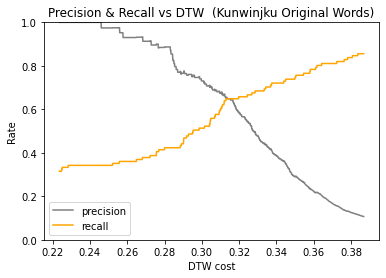

In [45]:
from matplotlib.pyplot import plot, title, xlabel, ylabel, savefig, legend, ylim
from numpy import array, arange

dtw_performance = []
dtw_threshold = []
max_f1 = 0

word_count = 0
for uttr in result:
    word_count += len(uttr['sentence'])
print(word_count)   

hasFoundRecall = False
for i in arange(mean(correct_dtw_score)-0.02,mean(incorrect_dtw_score),0.0001):
    p, r = get_score(i, correct_dtw_score, incorrect_dtw_score, word_count)
    f1 = 2*((p*r)/(p+r))
    if f1>max_f1:
        max_f1=f1
        default_dtw = i
        best_p = p
        best_r = r
    dtw_performance.append((p,r))
    dtw_threshold.append(i)
    
print('DTW: '+str(default_dtw)+'\nPrecision: '+str(best_p)+'\nRecall: '+str(best_r))
print('Max F1: '+str(max_f1))
dtw_threshold = array(dtw_threshold) 
#print(dtw_performance)
#print(dtw_threshold)

#recognised, 
precision, recall = zip(*dtw_performance)
colors_and_labels = (
   # (recognised, 'green', 'rate'),
    (precision, 'grey', 'precision'),
    (recall, 'orange', 'recall')
)

for performance, color, label in colors_and_labels:
    plot(dtw_threshold, array(performance), color=color, label=label)
title('Precision & Recall vs DTW '+plot_title)
xlabel('DTW cost')
ylabel('Rate')
ylim(0,1)
legend()

savefig(ftitle+'_accuracy.png', dpi=400)

In [46]:
for uttr_id in range(len(speech_utt)):
    spotted_words = []
    false_words = []
    fail_to_spot = []
    match = set()
    close_words = set()
    for query in word_list:        
        query_word = query["word"].lower()
        query_mfcc = np.float64(query["data"])
        search_mfcc = np.float64(speech_utt[uttr_id]["data"])
        dtw_costs = qbe.dtw_sweep(query_mfcc, search_mfcc)
        min_dtw = np.min(dtw_costs)
        utt_sent = word_tokenize(speech_utt[uttr_id]['word'].lower().replace('-',''))
        hasMatch = False               

        for utt_word in utt_sent:
            if min_dtw < default_dtw:
                if lev.distance(query_word,utt_word)<=thres_distance:
                    spotted_words.append(utt_word)
                    hasMatch = True
                    #print('Correct:')
                    #print(query_word)
                    break
            else:
                if lev.distance(query_word,utt_word)<=thres_distance:
                    #print(query_word,utt_word)
                    fail_to_spot.append(utt_word)
                    #play(query["audio"])
                    #play(speech_utt[uttr_id]["audio"])
                
        if hasMatch == False and min_dtw < default_dtw:
            false_words.append(query_word) 
                #print('Incorrect:')
                #print(query_word)
        
                #print('Fail to Spot:')
                #print(query_word)

    print('Utterance: \t'+speech_utt[uttr_id]['word'])
    print('Spotted Words:', end='\t')
    for word in spotted_words:
        print(word, end=' ') 
    print('\nFalse Positive:', end='\t')
    for word in false_words:
        print(word, end=' ')
    print('\nFailed to Spot:', end='\t')
    for word in fail_to_spot:
        print(word, end=' ')
    print('\n') 


Utterance: 	yolyolme njale-ken Bininj, ngurri-re Bushwalk njale-ken
Spotted Words:	njaleken yolyolme 
False Positive:	
Failed to Spot:	

Utterance: 	ngarri-djal-re wanjh, ngarri-re
Spotted Words:	
False Positive:	
Failed to Spot:	wanjh 

Utterance: 	kun-wale kumekke wurdwurd kabirri-nan
Spotted Words:	kabirrinan wurdwurd 
False Positive:	karrme ngarrinan 
Failed to Spot:	

Utterance: 	ngurlken ngarri-re
Spotted Words:	ngurlken ngurlken 
False Positive:	manih 
Failed to Spot:	

Utterance: 	ba bu yerre yiman kayime kabirri-bolbme
Spotted Words:	kabirribolbme yerre yiman 
False Positive:	kabirri 
Failed to Spot:	kayime 

Utterance: 	ngandi-nan ngadberre kun-wale kabirri-nan
Spotted Words:	
False Positive:	kabirri ngarriwam 
Failed to Spot:	kabirrinan ngadberre 

Utterance: 	wanjh kabirri-m-mang kabirri karrme bedman-wali
Spotted Words:	bedmanwali kabirri karrme 
False Positive:	yiman 
Failed to Spot:	wanjh 

Utterance: 	bu yiman kayime ngad wanjh ngarri-kohbanjmen 
Spotted Words:	kayime y

## Save Data

In [47]:
data = {}
data['result'] = result
data['match_dtw'] = correct_dtw_score
data['nomatch_dtw'] = incorrect_dtw_score
data['precision']= best_p
data['recall'] = best_r
data['dtw']= default_dtw
data['maxf1']= max_f1

In [48]:
with open(ftitle+'.data', 'wb') as filehandle:
    pickle.dump(data, filehandle)